# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [5]:
import numpy as np
import os
import datetime
import os

In [6]:
import matplotlib.pyplot as plt

In [3]:
# !pip uninstall scipy
!pip install scipy==1.1.0
!pip install Pillow

     |████████████████████████████████| 31.2MB 142kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [7]:
from scipy.misc.pilutil import imread, imresize

We set the random seed so that the results don't vary drastically.

In [8]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)


### set_random_seed is deperacated

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
# train_doc = np.random.permutation(open('/content/gdrive/My Drive/GestureRecognition/Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('/content/gdrive/My Drive/GestureRecognition/Project_data/val.csv').readlines())
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [10]:
batch_size =64
x = 18
y =100
z=100

In [11]:
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = imresize(img, (y,z))
    return resized_image

In [47]:
# import scipy.misc as mi 
# from scipy.misc.pilutil import Image
# import imageio

In [ ]:
imgx = imread('/content/gdrive/My Drive/GestureRecognition/Project_data/train/'+'WIN_20180926_18_09_50_Pro_Right_Swipe_new/WIN_20180926_18_09_50_Pro_00023.png')

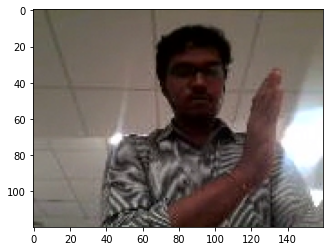

In [55]:
plt.imshow(np.uint8(imgx))

## after cropping

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


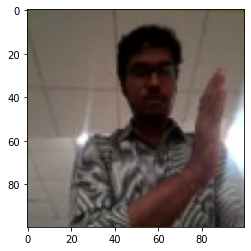

In [59]:
demoImage1 = crop_resize_img(imgx)
plt.imshow(np.uint8(demoImage1))

In [12]:
def normalize_image(img):
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

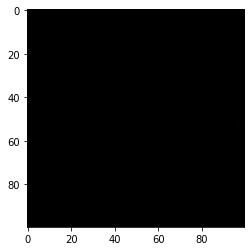

In [60]:
demoImageNormalise = normalize_image(demoImage1)
plt.imshow(np.uint8(demoImageNormalise))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
print(len(img_idx))

18


In [27]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)/batch_size
        num_batches = int(num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                # print( os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_resize_img(image)
                    image_resized=imresize(image,(y,z,3))
                    batch_data[folder,idx,:,:,0] = normalize_image(image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(image_resized[:,:,2]) #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        if(len(folder_list) != batch_size*num_batches):
          batch_size = len(folder_list) - (batch_size*num_batches)
          print('new batch size')
          print(batch_size)
          batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(batch_size):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
              image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
              image = crop_resize_img(image)
              image_resized=imresize(image,(y,z,3))
              batch_data[folder,idx,:,:,0] = normalize_image(image_resized[:,:,0])
              batch_data[folder,idx,:,:,1] = normalize_image(image_resized[:,:,1])
              batch_data[folder,idx,:,:,2] = normalize_image(image_resized[:,:,2])
              batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D ,Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here

In [17]:
filtersize =(3,3,3)
dense_neurons =64

In [13]:
model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=(30,y,z,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 50, 50, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
print(os.path.abspath(model_name))

/content/model_init_2021-03-0315_07_37.018112


In [29]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name)
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
#LR = # write the REducelronplateau code here
# LR = ReduceLROnPlateau(monitor='loss',
#                                    factor=0.1,
#                                    cooldown=0,
#                                    patience=10,
#                                    min_lr=1e-4)
callbacks_list = [checkpoint, LR]

W0307 15:46:05.211443 139800168597312 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


model_init_2021-03-0715_38_33.539608/


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
print(num_epochs)

30


In [31]:
history =model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/30
 9/11 [=======================>......] - ETA: 8s - loss: 1.3333 - categorical_accuracy: 0.4566 new batch size
23


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


11/11 [==============================] - ETA: 0s - loss: 1.2988 - categorical_accuracy: 0.4344Source path =  Project_data/val ; batch size = 64
new batch size
36

Epoch 00001: saving model to model_init_2021-03-0612_12_49.008843/model-00001-1.29877-0.43439-1.05147-0.16000.h5
11/11 [==============================] - 60s 5s/step - loss: 1.2988 - categorical_accuracy: 0.4344 - val_loss: 1.0515 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.5717 - categorical_accuracy: 0.1225
Epoch 00002: saving model to model_init_2021-03-0612_12_49.008843/model-00002-0.57169-0.12253-0.14024-0.04167.h5
11/11 [==============================] - 5s 437ms/step - loss: 0.5717 - categorical_accuracy: 0.1225 - val_loss: 0.1402 - val_categorical_accuracy: 0.0417 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.6803 - categorical_accuracy: 0.5494
Epoch 00003: saving model to model_init_2021-03-0612_12_49.008843

Epoch 21/30
11/11 [==============================] - ETA: 0s - loss: 0.9312 - categorical_accuracy: 0.6043
Epoch 00021: saving model to model_init_2021-03-0612_12_49.008843/model-00021-0.93123-0.60428-2.32313-0.07143.h5
11/11 [==============================] - 14s 1s/step - loss: 0.9312 - categorical_accuracy: 0.6043 - val_loss: 2.3231 - val_categorical_accuracy: 0.0714 - lr: 1.6000e-06
Epoch 22/30
11/11 [==============================] - ETA: 0s - loss: 0.8687 - categorical_accuracy: 0.6417
Epoch 00022: saving model to model_init_2021-03-0612_12_49.008843/model-00022-0.86873-0.64171-2.63191-0.07143.h5

Epoch 00022: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
11/11 [==============================] - 14s 1s/step - loss: 0.8687 - categorical_accuracy: 0.6417 - val_loss: 2.6319 - val_categorical_accuracy: 0.0714 - lr: 1.6000e-06
Epoch 23/30
11/11 [==============================] - ETA: 0s - loss: 1.0149 - categorical_accuracy: 0.5775
Epoch 00023: saving model to mod

In [21]:
def plotGraph(history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  axes[0].plot(history.history['loss'])   
  axes[0].plot(history.history['val_loss'])
  axes[0].legend(['loss','val_loss'])
  axes[1].plot(history.history['categorical_accuracy'])   
  axes[1].plot(history.history['val_categorical_accuracy'])
  axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## the below accuracy and loss is with learning rate 0.001

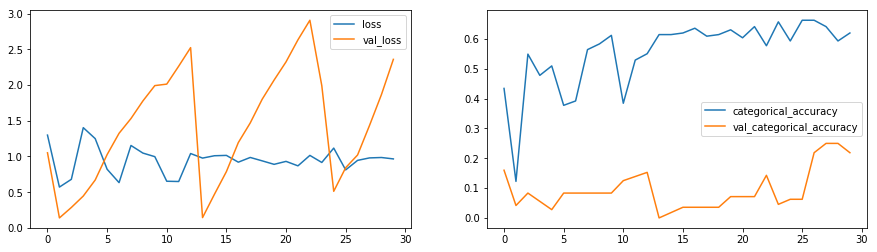

In [33]:
plotGraph(history)

# there was huge rise in learning rate at epoch 3, The only difference was the learning rate here was 0.02 which is much bigger as compared to 0.001 which with the above trained model

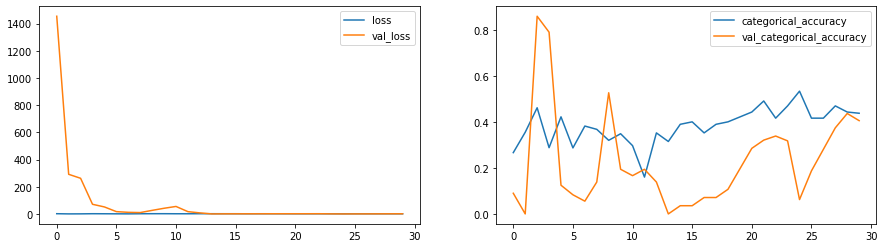

In [ ]:
plotGraph(history)

## now trying out with Generator which is skipping image after every Indexes

In [34]:
class Builder():
  def set_image_properties(self,image_height,image_width):   
    self.image_height=image_height
    self.image_width=image_width
    self.channels=3
    self.num_classes=5
    self.total_frames=30
      
  def set_hyperparams(self,frames_to_sample,batch_size,num_epochs):
    self.frames_to_sample=frames_to_sample
    self.batch_size=batch_size
    self.num_epochs=num_epochs

# RNN Model with LSTM Cell

In [35]:
filtersizeRNN = (2,2)

In [36]:
class RNNModelBuilder(Builder):
  def defineRNNModel(self, lstm_cells =64,dense_neurons=64,dropout=0.25):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=(x,y,z,3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))
    
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(self.num_classes, activation='softmax'))
    optimiser = optimizers.Adam(lr=0.00004)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [37]:
rnnObject = RNNModelBuilder()
rnnObject.set_image_properties(image_height=100,image_width=100)
rnnObject.set_hyperparams(frames_to_sample=19,batch_size=64,num_epochs=30)
rnnModel = rnnObject.defineRNNModel(lstm_cells=128,dense_neurons=64,dropout=0.25)
rnnModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 25, 25, 64)   

In [38]:
history =rnnModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=rnnObject.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.7033 - categorical_accuracy: 0.1658new batch size
4

Epoch 00001: saving model to model_init_2021-03-0612_12_49.008843/model-00001-1.70329-0.16578-1.60588-0.28125.h5
11/11 [==============================] - 15s 1s/step - loss: 1.7033 - categorical_accuracy: 0.1658 - val_loss: 1.6059 - val_categorical_accuracy: 0.2812 - lr: 4.0000e-05
Epoch 2/30


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


11/11 [==============================] - ETA: 0s - loss: 1.6474 - categorical_accuracy: 0.2299
Epoch 00002: saving model to model_init_2021-03-0612_12_49.008843/model-00002-1.64744-0.22995-1.01203-0.00000.h5
11/11 [==============================] - 14s 1s/step - loss: 1.6474 - categorical_accuracy: 0.2299 - val_loss: 1.0120 - val_categorical_accuracy: 0.0000e+00 - lr: 4.0000e-05
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.5939 - categorical_accuracy: 0.2513
Epoch 00003: saving model to model_init_2021-03-0612_12_49.008843/model-00003-1.59386-0.25134-1.62653-0.12500.h5
11/11 [==============================] - 14s 1s/step - loss: 1.5939 - categorical_accuracy: 0.2513 - val_loss: 1.6265 - val_categorical_accuracy: 0.1250 - lr: 4.0000e-05
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 1.4968 - categorical_accuracy: 0.3369
Epoch 00004: saving model to model_init_2021-03-0612_12_49.008843/model-00004-1.49677-0.33690-1.58658-0.12500.h5
11/11 [===

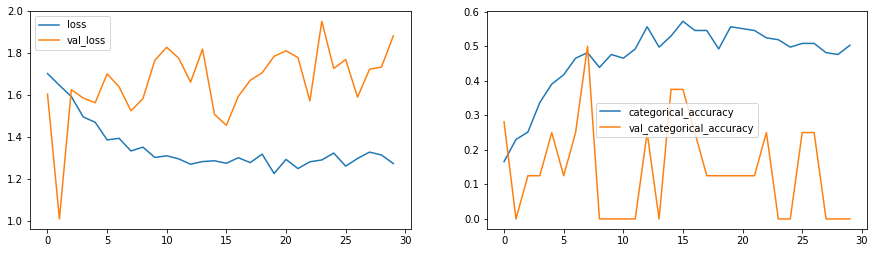

In [39]:
plotGraph(history)

# the below LSTM graph is created by training 30 epochs and changed the learning rate to 0.00004 

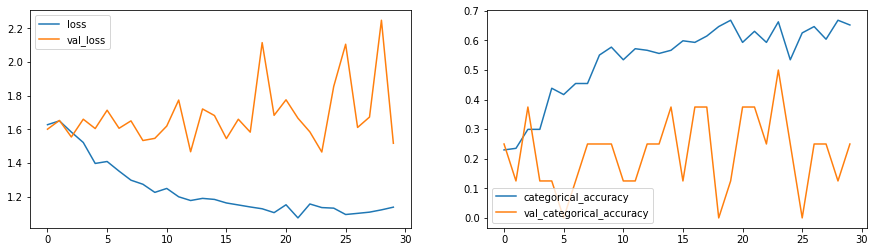

In [39]:
plotGraph(history)

## the below accuracy and loss is by using LSTM cell model for epochs =10

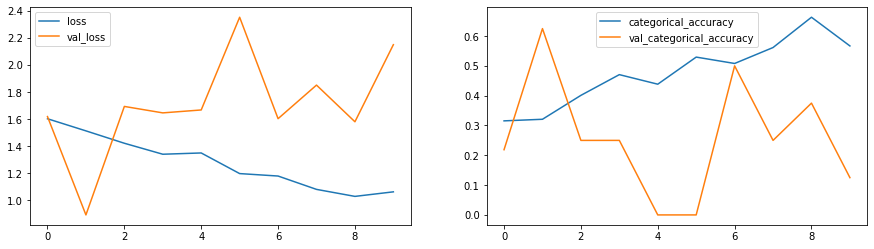

In [34]:
plotGraph(history)

## Transfer learning with GRU

In [22]:
IMG_SHAPE = (y,z, 3)
base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [1]:
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
print(len(img_idx))

18


In [23]:
for layer in base_model.layers:
    layer.trainable = False

In [33]:
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
  layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(18,100,100,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.05))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [37]:
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_Model = Model(inputs=base_model.input, outputs=features)
for layer in base_model.layers:
  layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_Model,input_shape=(18,y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.25))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 18, 64)            20319360  
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 64)            256       
_________________________________________________________________
gru_6 (GRU)                  (None, 18, 64)            24960     
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)               

In [39]:
history =model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.6300 - categorical_accuracy: 0.2513
Epoch 00001: saving model to model_init_2021-03-0715_38_33.539608/model-00001-1.63000-0.25134-1.68394-0.12500.h5
11/11 [==============================] - 17s 2s/step - loss: 1.6300 - categorical_accuracy: 0.2513 - val_loss: 1.6839 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.4865 - categorical_accuracy: 0.3850
Epoch 00002: saving model to model_init_2021-03-0715_38_33.539608/model-00002-1.48646-0.38503-1.71432-0.12500.h5
11/11 [==============================] - 15s 1s/step - loss: 1.4865 - categorical_accuracy: 0.3850 - val_loss: 1.7143 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.4336 - categorical_accuracy: 0.3636
Epoch 00003: saving model to model_init_2021-03-0715_38_33.539608/model-00003-1.43358-0.36364-1.68265-0.12500.h5
11/11 [====

Epoch 22/30
11/11 [==============================] - ETA: 0s - loss: 0.4052 - categorical_accuracy: 0.8770
Epoch 00022: saving model to model_init_2021-03-0715_38_33.539608/model-00022-0.40517-0.87701-0.71616-0.62500.h5
11/11 [==============================] - 15s 1s/step - loss: 0.4052 - categorical_accuracy: 0.8770 - val_loss: 0.7162 - val_categorical_accuracy: 0.6250 - lr: 4.0000e-05
Epoch 23/30
11/11 [==============================] - ETA: 0s - loss: 0.4288 - categorical_accuracy: 0.8396
Epoch 00023: saving model to model_init_2021-03-0715_38_33.539608/model-00023-0.42877-0.83957-1.52018-0.50000.h5
11/11 [==============================] - 15s 1s/step - loss: 0.4288 - categorical_accuracy: 0.8396 - val_loss: 1.5202 - val_categorical_accuracy: 0.5000 - lr: 4.0000e-05
Epoch 24/30
11/11 [==============================] - ETA: 0s - loss: 0.3824 - categorical_accuracy: 0.8717
Epoch 00024: saving model to model_init_2021-03-0715_38_33.539608/model-00024-0.38240-0.87166-1.20659-0.62500.h5


## with dene layer of 16 and dropout of 0.25

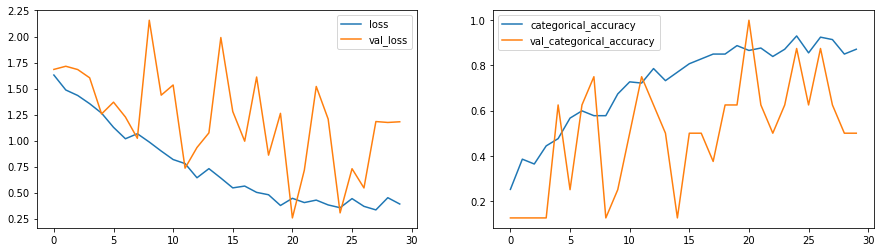

In [40]:
plotGraph(history)

## with dropout of 0.5 and dene layer of 8

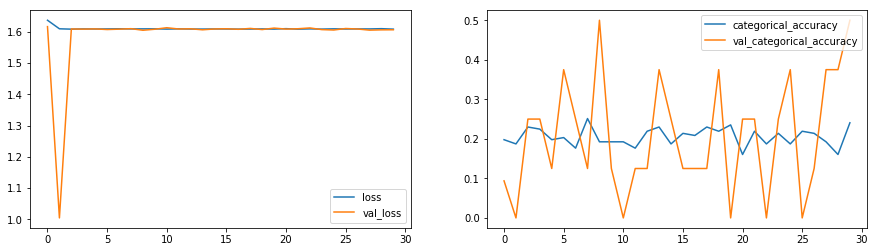

In [35]:
plotGraph(history)

## with dropout of 0.5

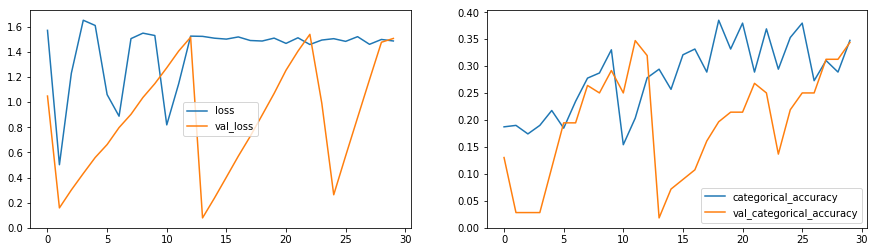

In [32]:
plotGraph(history)